# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

In [3]:
def Gaussian_filter_2d_Rot(x, y, x0, y0, xs, ys, angle, A):
    cx = x[np.newaxis,:]*np.ones_like(y)[:,np.newaxis]  -x0
    cy = np.ones_like(x)[np.newaxis,:]*y[:,np.newaxis]-y0
    rx =  cx*np.cos(angle) - cy*np.sin(angle) 
    ry =  cx*np.sin(angle) + cy*np.cos(angle)
    return A*(np.exp(-((rx/xs)**2+(ry/ys)**2)/2))

# Main

In [4]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)

figmap = [[np.nan, 7,15,23,31,39,47,np.nan],
          [     1, 8,16,24,32,40,48,    55],
          [     2, 9,17,25,33,41,49,    56],
          [     3,10,18,26,34,42,50,    57],
          [     4,11,19,27,35,43,51,    58],
          [     5,12,20,28,36,44,52,    59],
          [     6,13,21,29,37,45,53,    60],
          [np.nan,14,22,30,38,46,54,np.nan]]
figmap = np.array(figmap)

In [5]:
exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\'
ensure_dir(exp_folder+'STA')
ensure_dir(exp_folder+'STA\\Fig')

RFprop  = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties.mat', squeeze_me =True)
RFprop = RFprop['RF_properties']

dt = 1./60.
timeshift = np.arange(-1,1,dt)

In [6]:
for filename in os.listdir(exp_folder+'merge\\'):
    if filename.find('HMM')==-1 and filename.find('OU')==-1:    continue
    for direction in ['RL', 'UD', 'UR_DL', 'UL_DR']:
        if filename.find(direction) != -1: break
    if direction != 'UD':    continue
        
    MBExp = loadmat(exp_folder+'merge\\'+filename, squeeze_me =True)
    BarPos = MBExp['bin_pos']
    T=np.arange(len(BarPos))*dt+dt
    XcT = T-T[int(len(T)/2)]
    
    STA_cell = [0]*60 
    Inten_cell = [0]*60 
    for cn in np.arange(1,61):
        rstate, _ = np.histogram(MBExp['reconstruct_spikes'][cn-1], np.append(0,T))
        if not RFprop[cn-1]['Amplitude']:     continue
        if sum(rstate)/len(rstate)/dt <= 0.3 : continue
            
        RFellipse = Gaussian_filter_2d_Rot(np.arange(1,801), np.arange(1,601), 
                                           RFprop[cn-1]['X_Coor'], RFprop[cn-1]['Y_Coor'],
                                           RFprop[cn-1]['X_Width']/1.5/BS['micro_per_pixel'],
                                           RFprop[cn-1]['Y_Width']/1.5/BS['micro_per_pixel'],
                                           RFprop[cn-1]['Angle'], RFprop[cn-1]['Amplitude'])
        if direction == 'UD':
            Inten_cell[cn-1] = np.array([np.sum(RFellipse[bp-100-BS['bar_wid']:bp-100+BS['bar_wid'],
                                                          400-BS['bar_le']:400+BS['bar_wid']])  for bp in BarPos])
        x = Inten_cell[cn-1].copy()
        x = x.astype(float)
        x = (x-np.mean(x))/np.std(x)
        nXcorr = np.correlate(x, rstate, 'same')/np.correlate(np.ones_like(x), rstate, 'same')
        STA_cell[cn-1] = nXcorr[np.arange(np.where(XcT == -1)[0],np.where(XcT == 1)[0])]
    filename = filename[:-4]
    np.savez(exp_folder+'STA\\STA_'+filename+'.npz', STA_cell = STA_cell, timeshift = timeshift)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


# fc

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

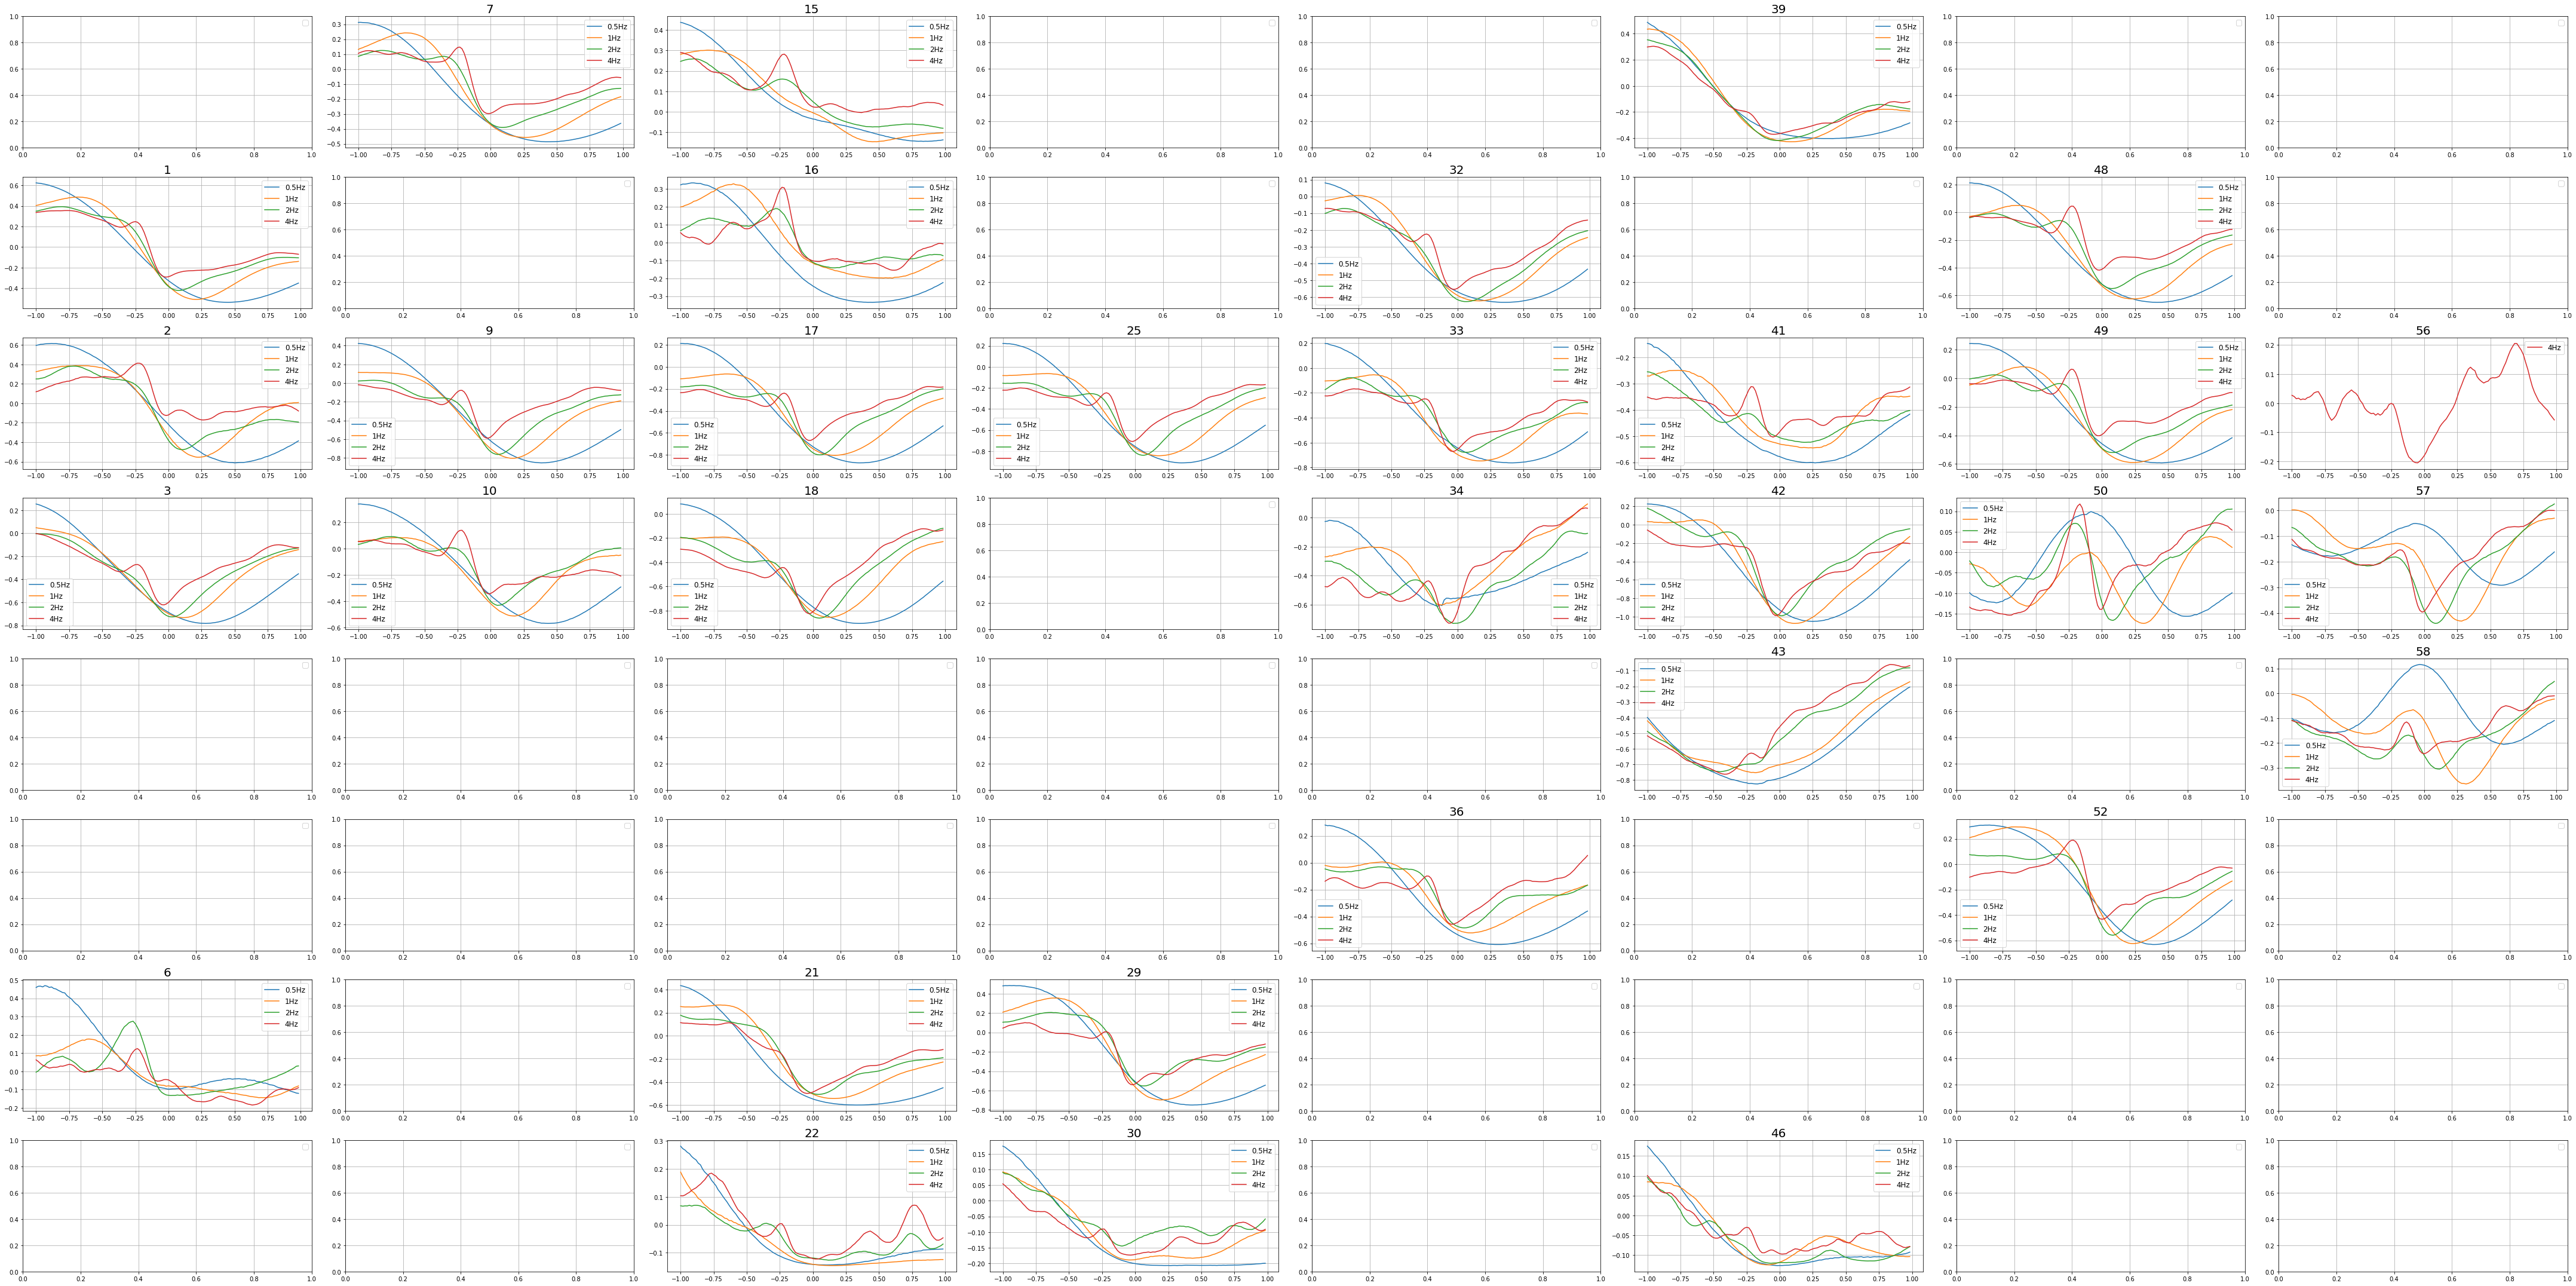

In [15]:
fig, ax = plt.subplots(nrows=8, ncols=8)
cmind = 0
for Fc in [0.5,1,2,4]:
    filename = 'merge_0727_OUsmooth_Bright_'+direction+'_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz'
    loadfiles = np.load(exp_folder+'STA\\STA_'+filename+'.npz', allow_pickle=True)
    for k in loadfiles.files:
        vars()[k] = loadfiles[k][()]
    
    for cn in range(60):
        STA = STA_cell[cn]
        if type(STA) == int: continue
        ax[np.where(figmap == cn+1)][0].plot(timeshift, STA, label=str(Fc)+'Hz', color = plt.cm.tab10(cmind))
        ax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 20)
    cmind += 1
    
for ax1d in ax:
    for ax in ax1d:
        ax.legend(fontsize = 12)
        ax.grid()
        
fig.set_size_inches(60, 30)
fig.tight_layout()
fig.savefig(exp_folder+'STA\\Fig\\dFc_BB.tif', bbox_inches = 'tight',pad_inches = 0.3)

# BW

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

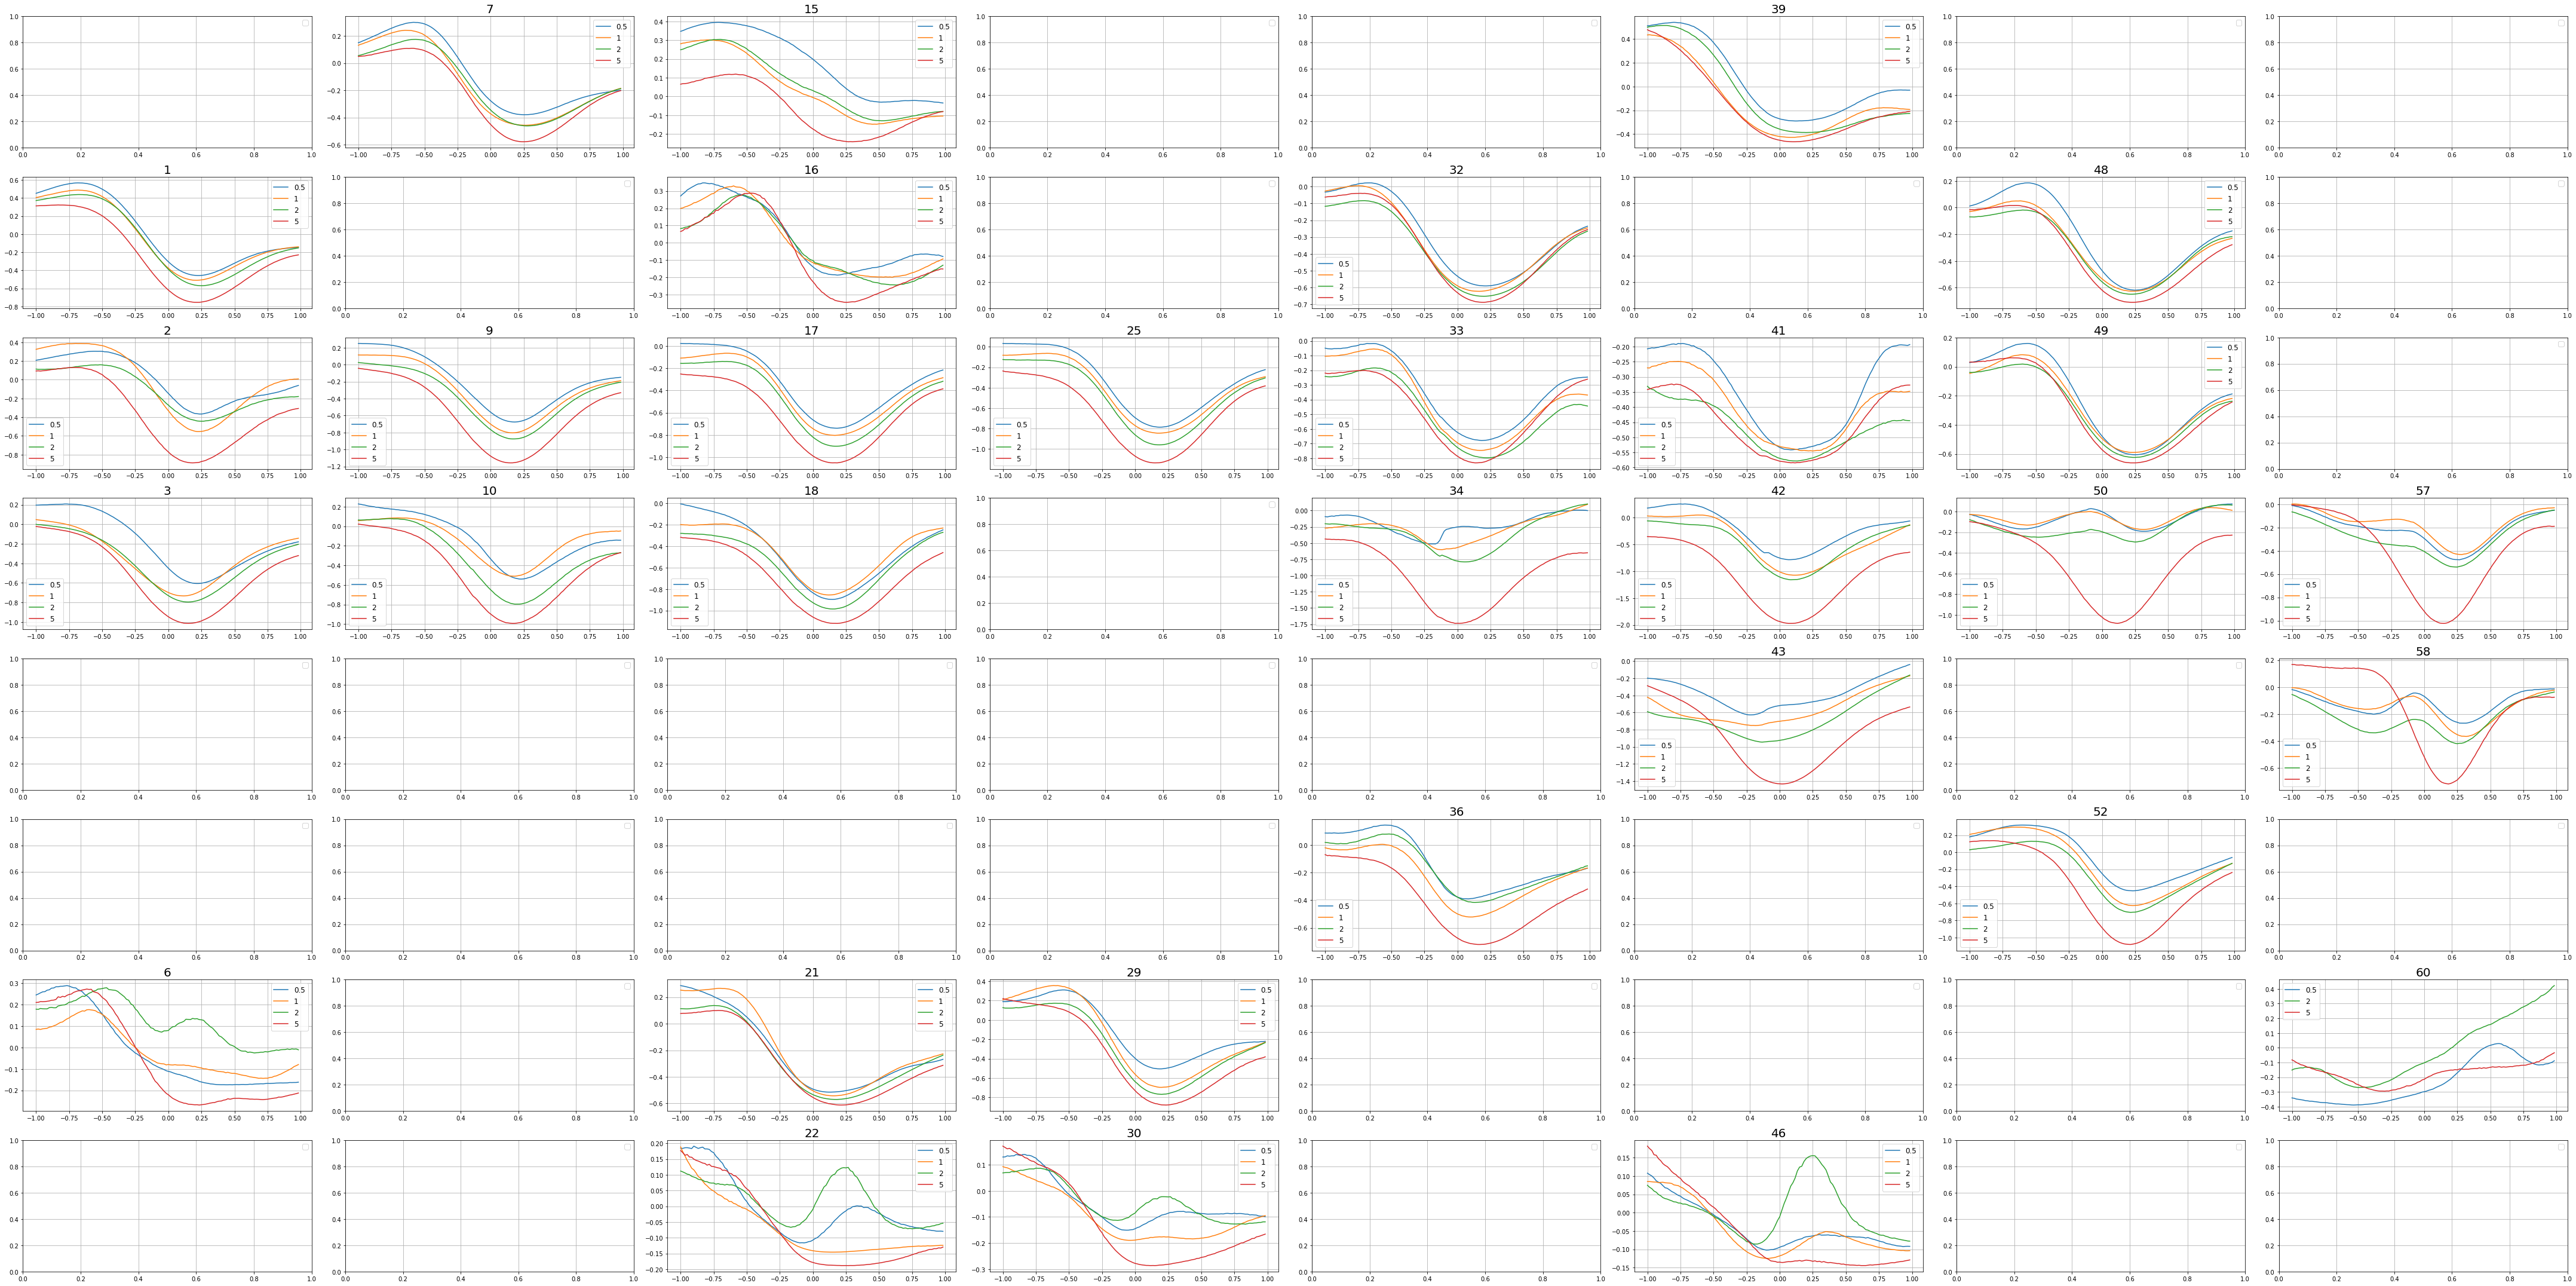

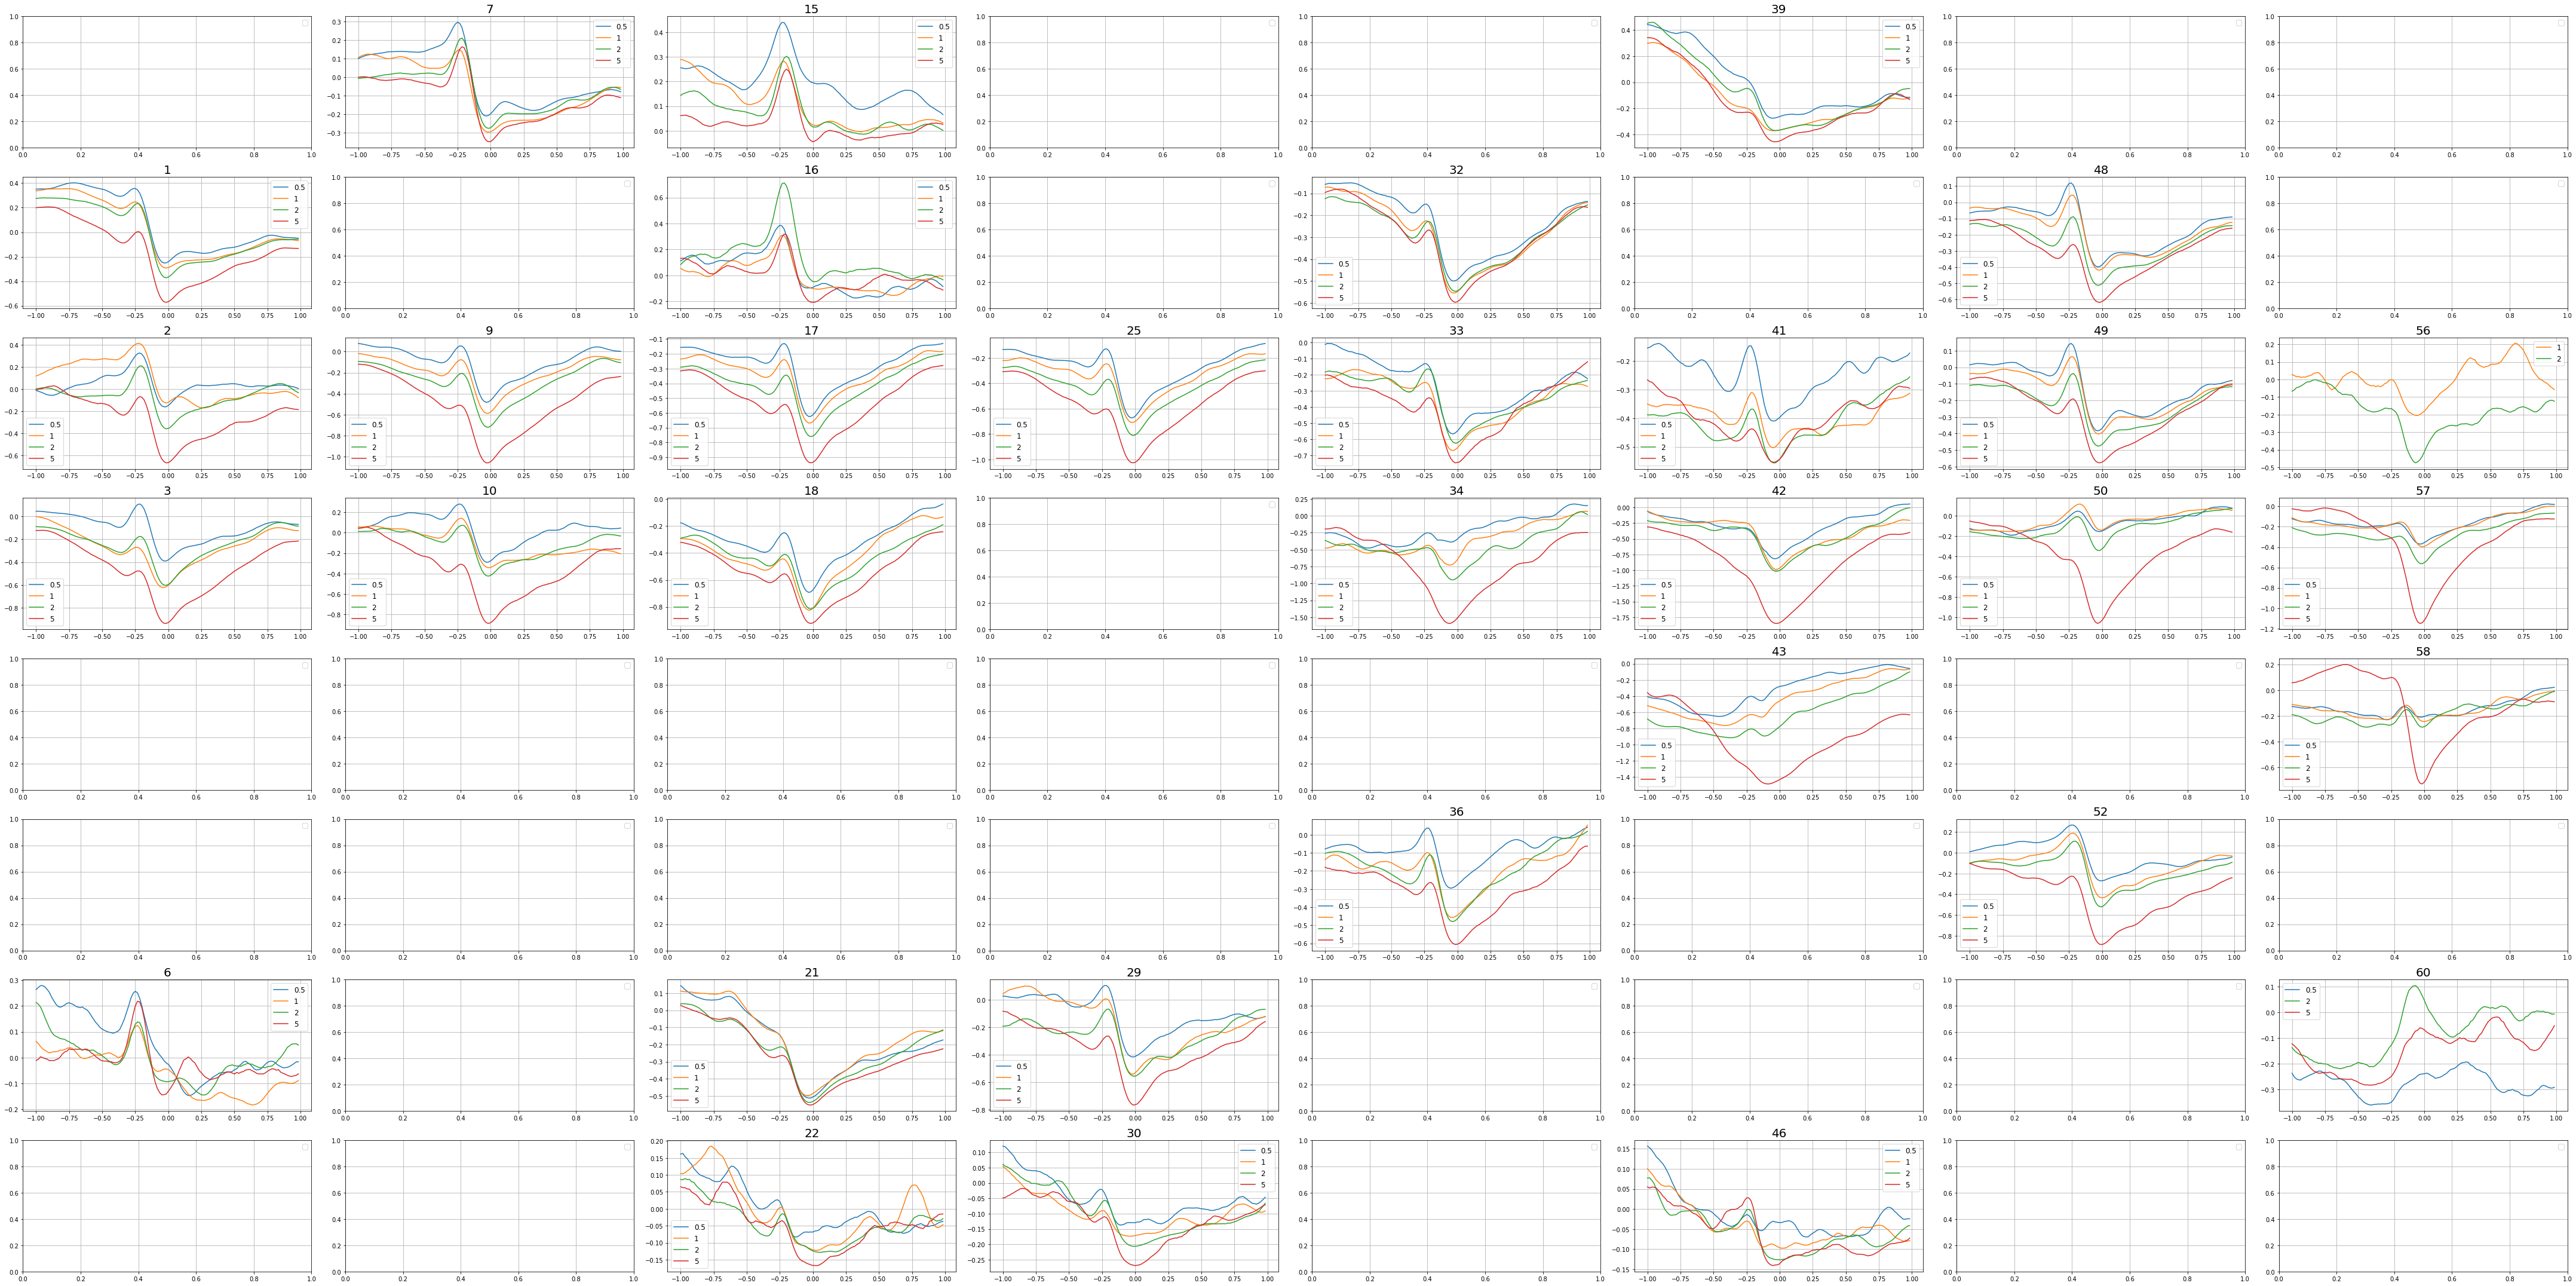

In [16]:
bW = [0.5,1,2,5]
direction = 'UD'
for Fc in [1,4]:
    fig, ax = plt.subplots(nrows=8, ncols=8)
    cmind = 0
    files = ['merge_0102_OUsmooth_Bright_'+direction+'_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz',
             'merge_0727_OUsmooth_Bright_'+direction+'_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz',
             'merge_2222_OUsmooth_Bright_'+direction+'_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz',
             'merge_5555_OUsmooth_Bright_'+direction+'_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz',]
    for i in range(len(files)):
        loadfiles = np.load(exp_folder+'STA\\STA_'+files[i]+'.npz', allow_pickle=True)
        for k in loadfiles.files:
            vars()[k] = loadfiles[k][()]

        for cn in range(60):
            STA = STA_cell[cn]
            if type(STA) == int: continue
            ax[np.where(figmap == cn+1)][0].plot(timeshift, STA, label=str(bW[i]), color = plt.cm.tab10(cmind))
            ax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 20)
        cmind += 1

    for ax1d in ax:
        for ax in ax1d:
            ax.legend(fontsize = 12)
            ax.grid()

    fig.set_size_inches(60, 30)
    fig.tight_layout()
    fig.savefig(exp_folder+'STA\\Fig\\dBarWid_BB.tif', bbox_inches = 'tight',pad_inches = 0.3)  

# Sigma

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

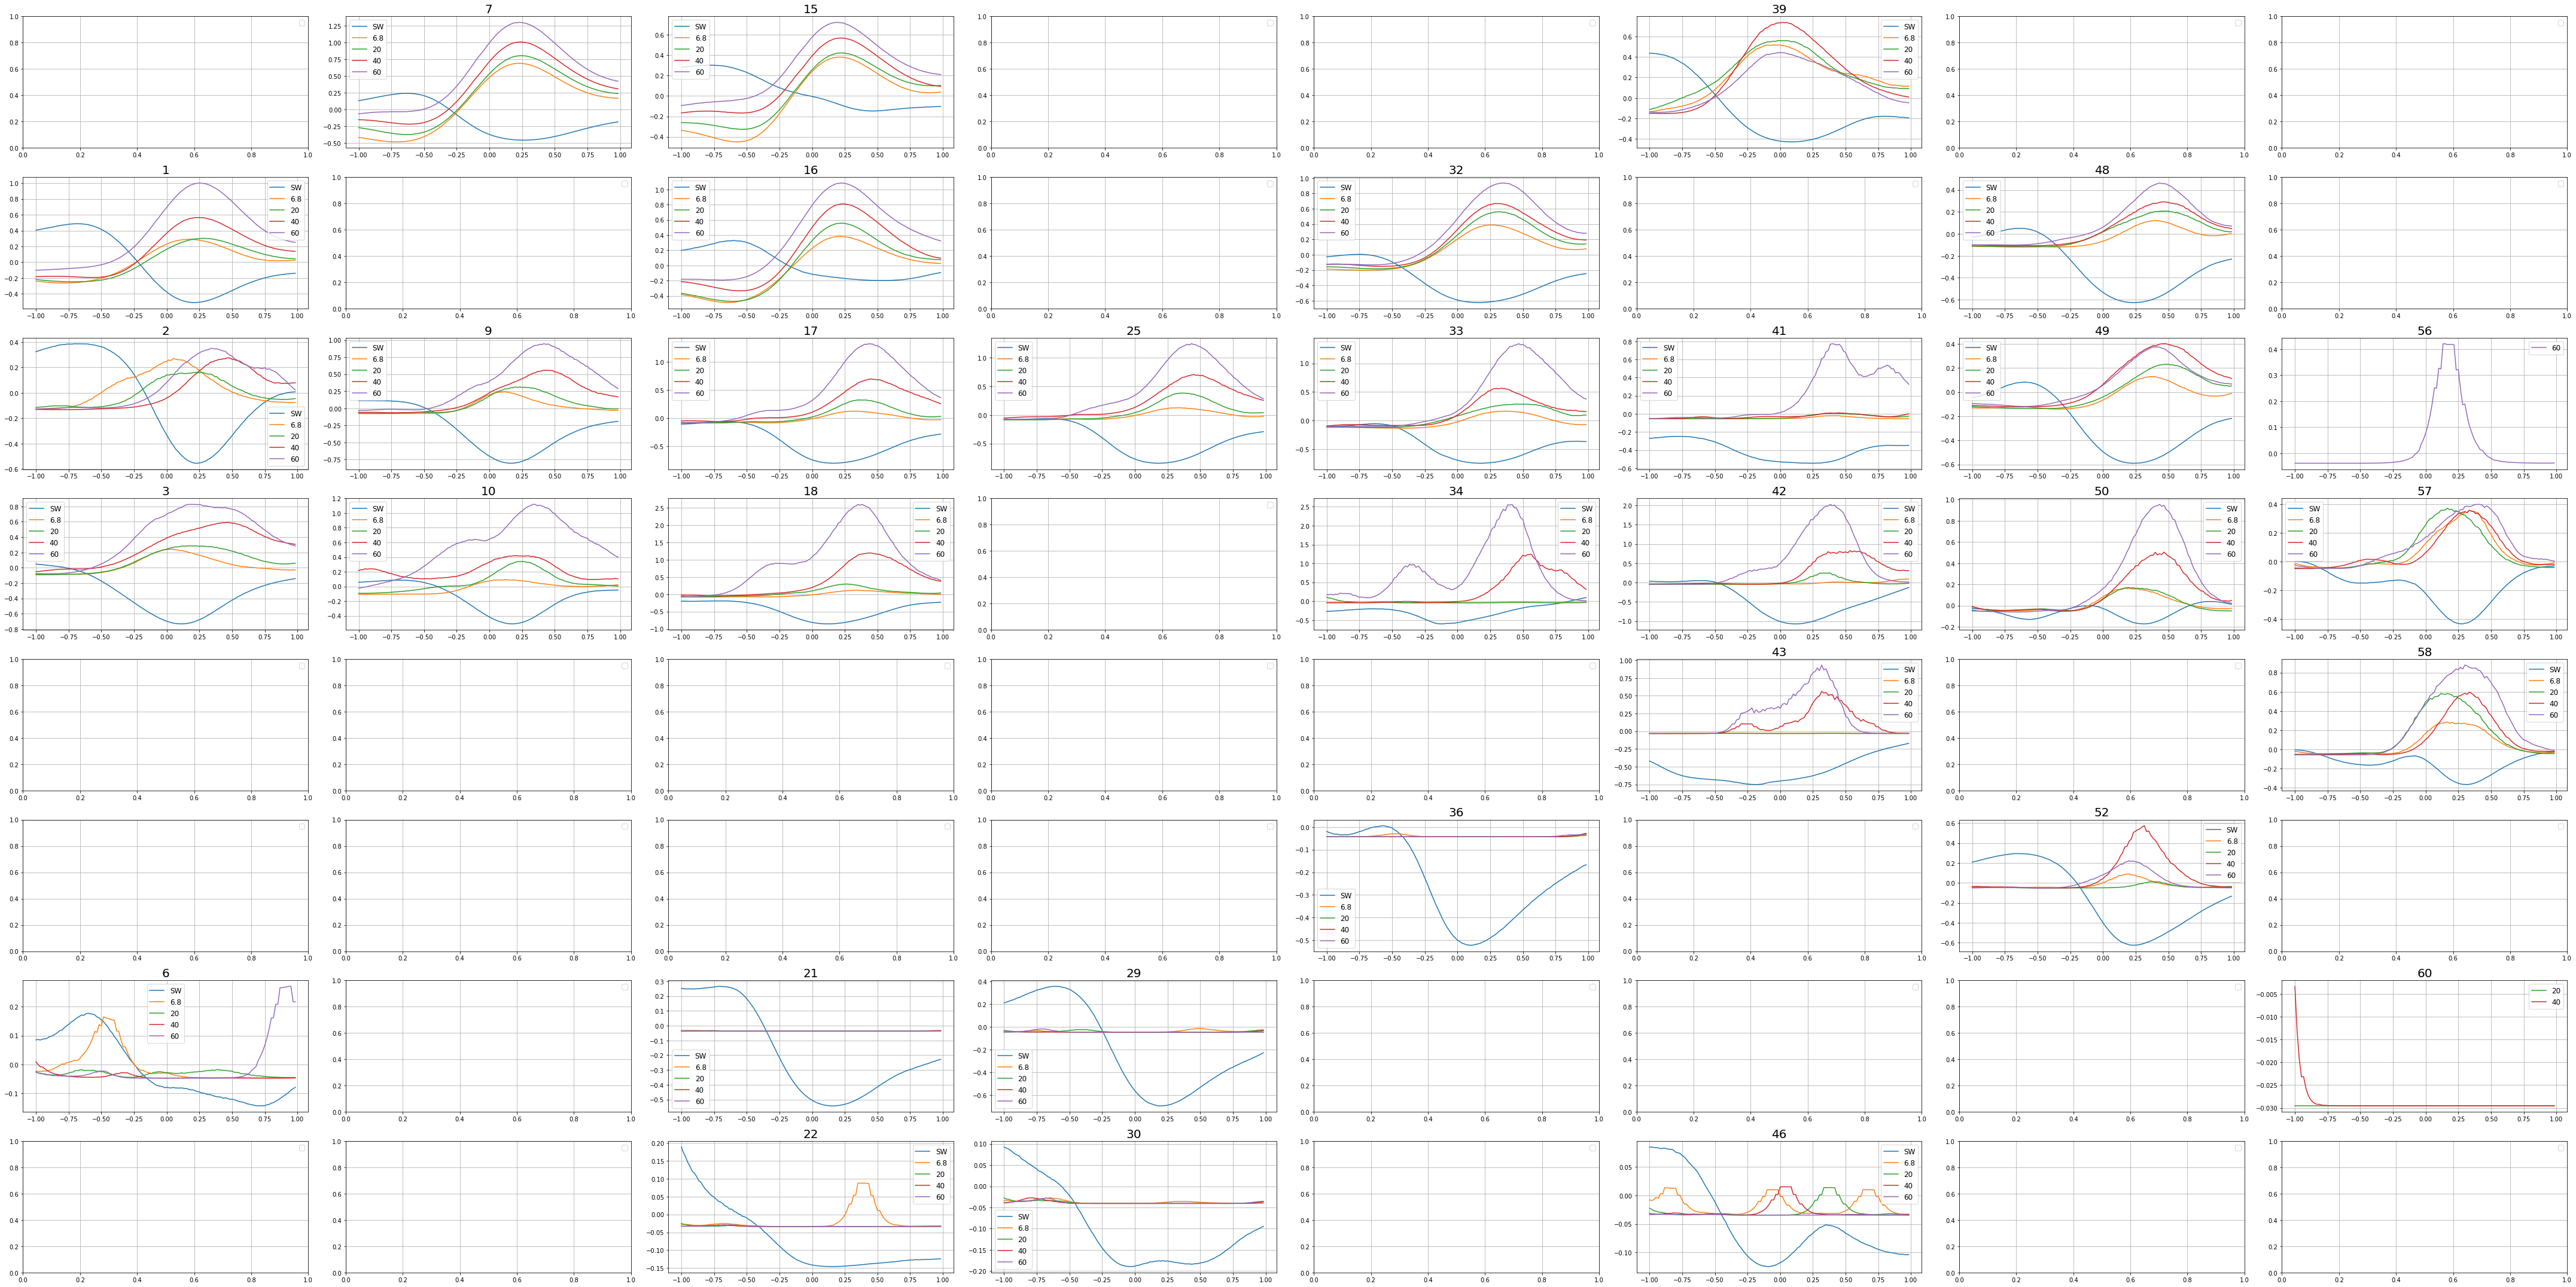

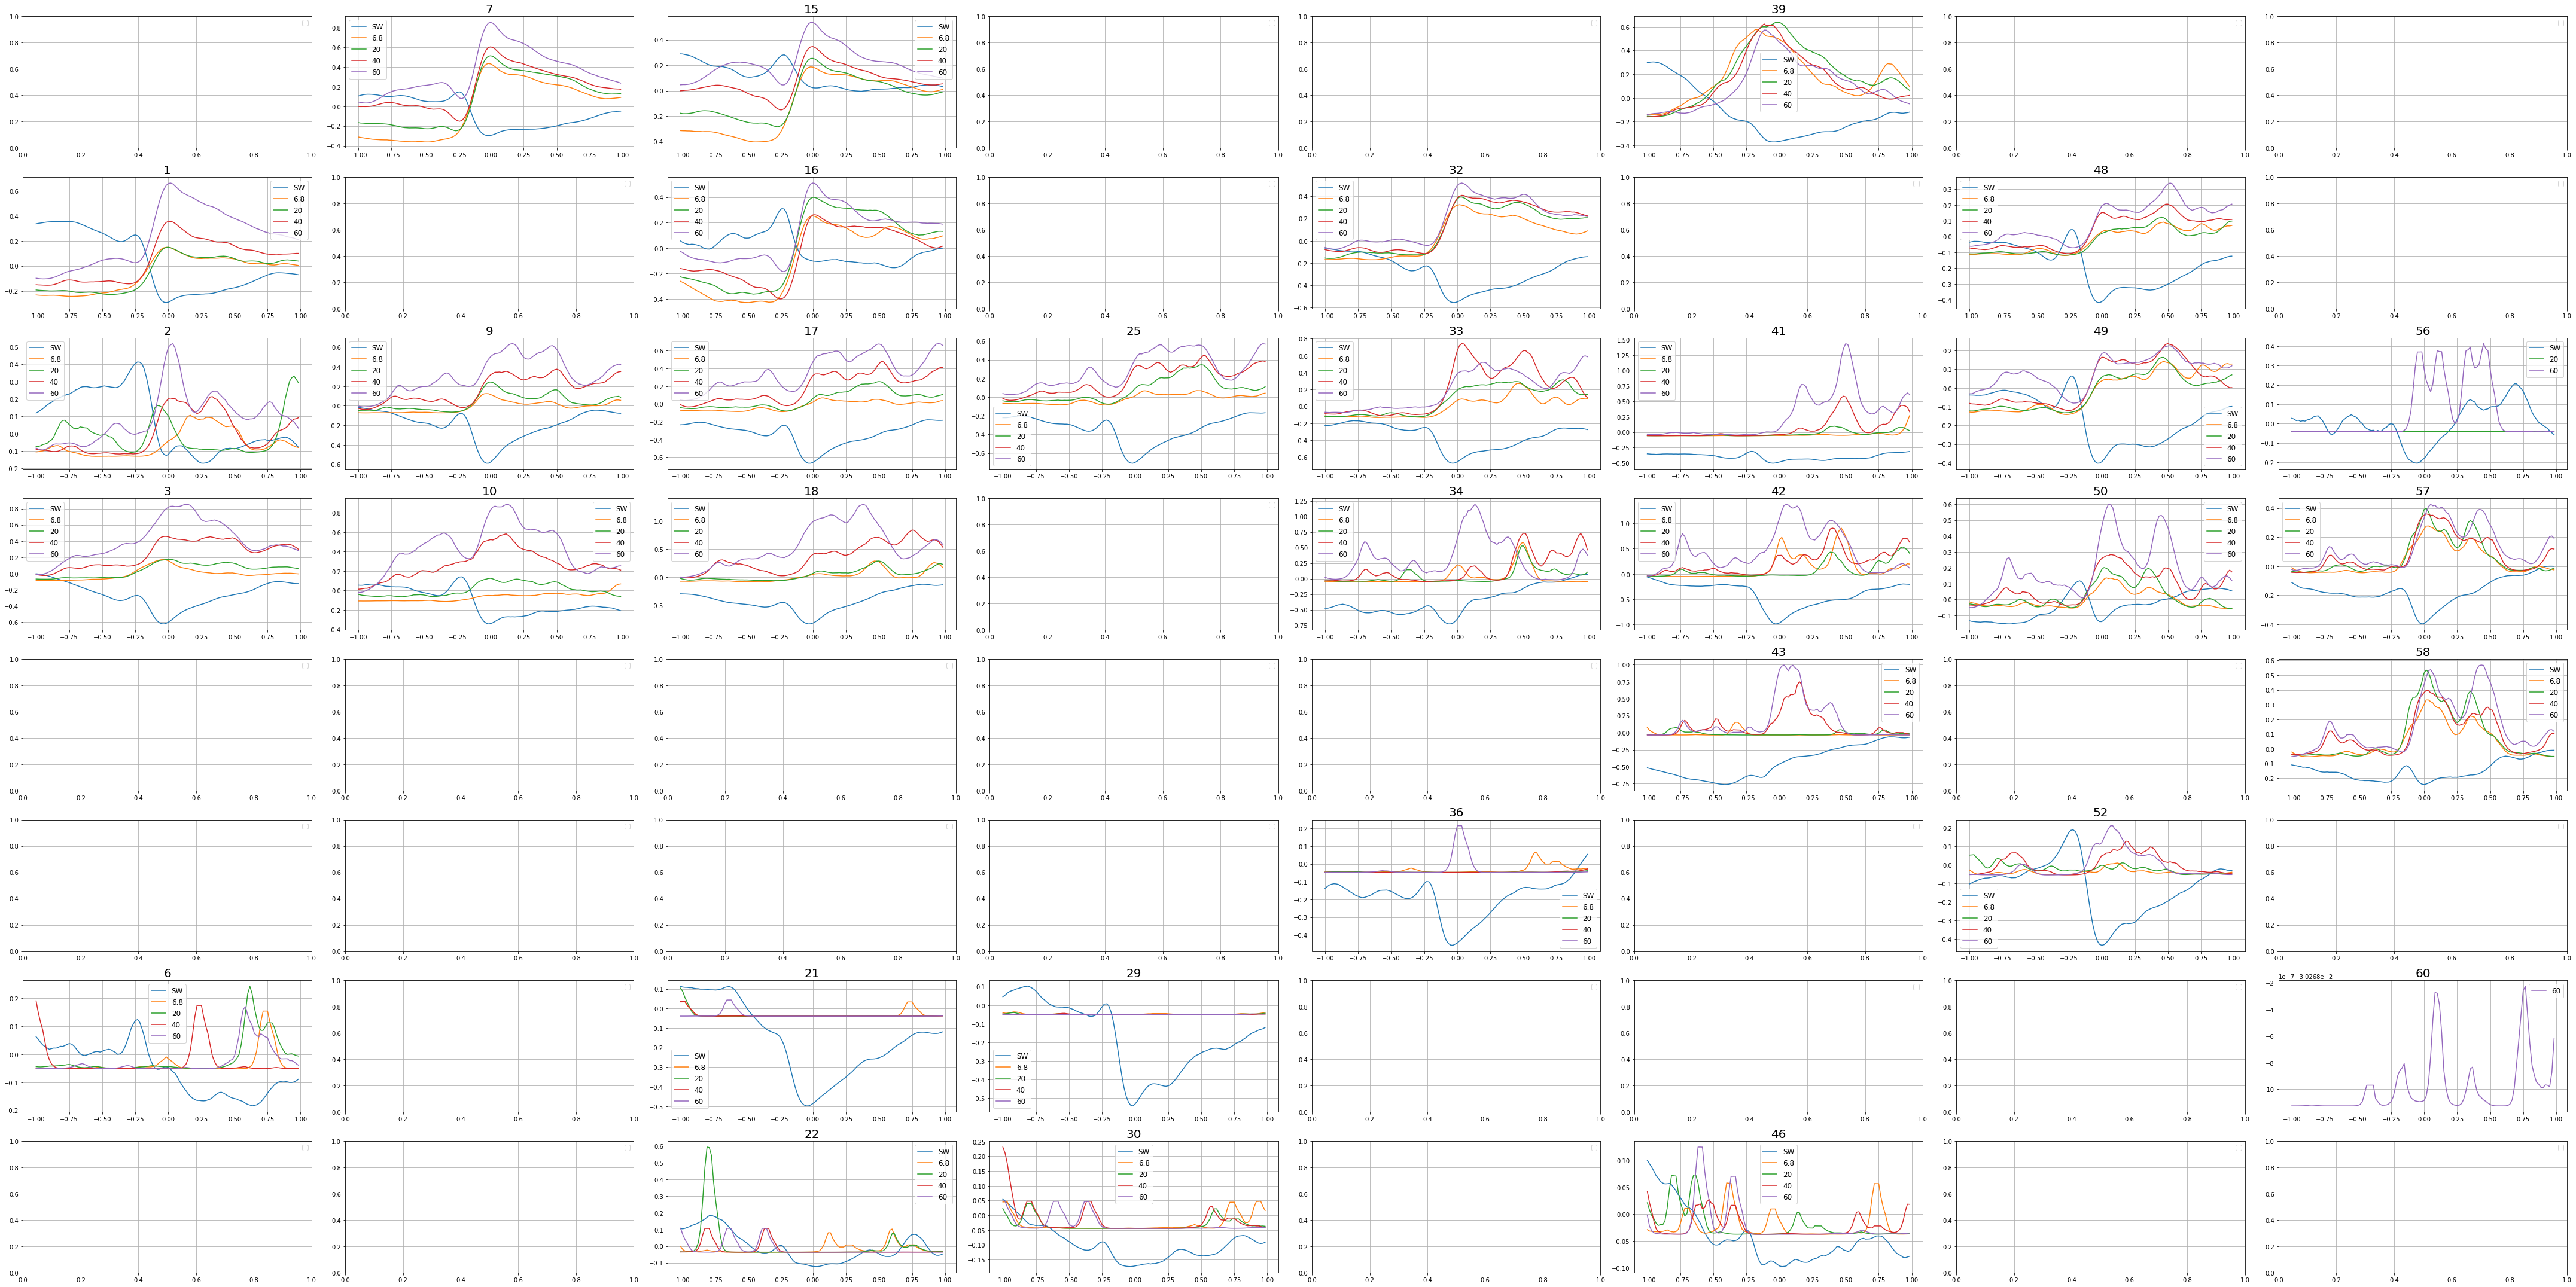

In [17]:
sigma = ['SW', '6.8', '20', '40', '60']
direction = 'UD'
for Fc in [1,4]:
    fig, ax = plt.subplots(nrows=8, ncols=8)
    cmind = 0
    files = ['merge_0727_OUsmooth_Bright_'+direction+'_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz',
             'merge_0505_GP_s=6.8_OUsmooth_'+str(Fc)+'Hz_'+direction+'_6.5v0mW', 
             'merge_0505_GP_s=20_OUsmooth_'+str(Fc)+'Hz_'+direction+'_6.5v0mW', 
             'merge_0505_GP_s=40_OUsmooth_'+str(Fc)+'Hz_'+direction+'_6.5v0mW',
             'merge_0505_GP_s=60_OUsmooth_'+str(Fc)+'Hz_'+direction+'_6.5v0mW']
    for i in range(len(files)):
        loadfiles = np.load(exp_folder+'STA\\STA_'+files[i]+'.npz', allow_pickle=True)
        for k in loadfiles.files:
            vars()[k] = loadfiles[k][()]

        for cn in range(60):
            STA = STA_cell[cn]
            if type(STA) == int: continue
            ax[np.where(figmap == cn+1)][0].plot(timeshift, STA, label=sigma[i], color = plt.cm.tab10(cmind))
            ax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 20)
        cmind += 1

    for ax1d in ax:
        for ax in ax1d:
            ax.legend(fontsize = 12)
            ax.grid()

    fig.set_size_inches(60, 30)
    fig.tight_layout()
    fig.savefig(exp_folder+'STA\\Fig\\dSigma_BB.tif', bbox_inches = 'tight',pad_inches = 0.3)  

# Background Intensity

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

FileNotFoundError: [Errno 2] No such file or directory: "D:\\GoogleDrive\\retina\\Chou's data\\20210513\\STA\\STA_merge_0727_OUsmooth_UD_G4.5_5min_Q100_0.05mW_12900_4Hz.npz"

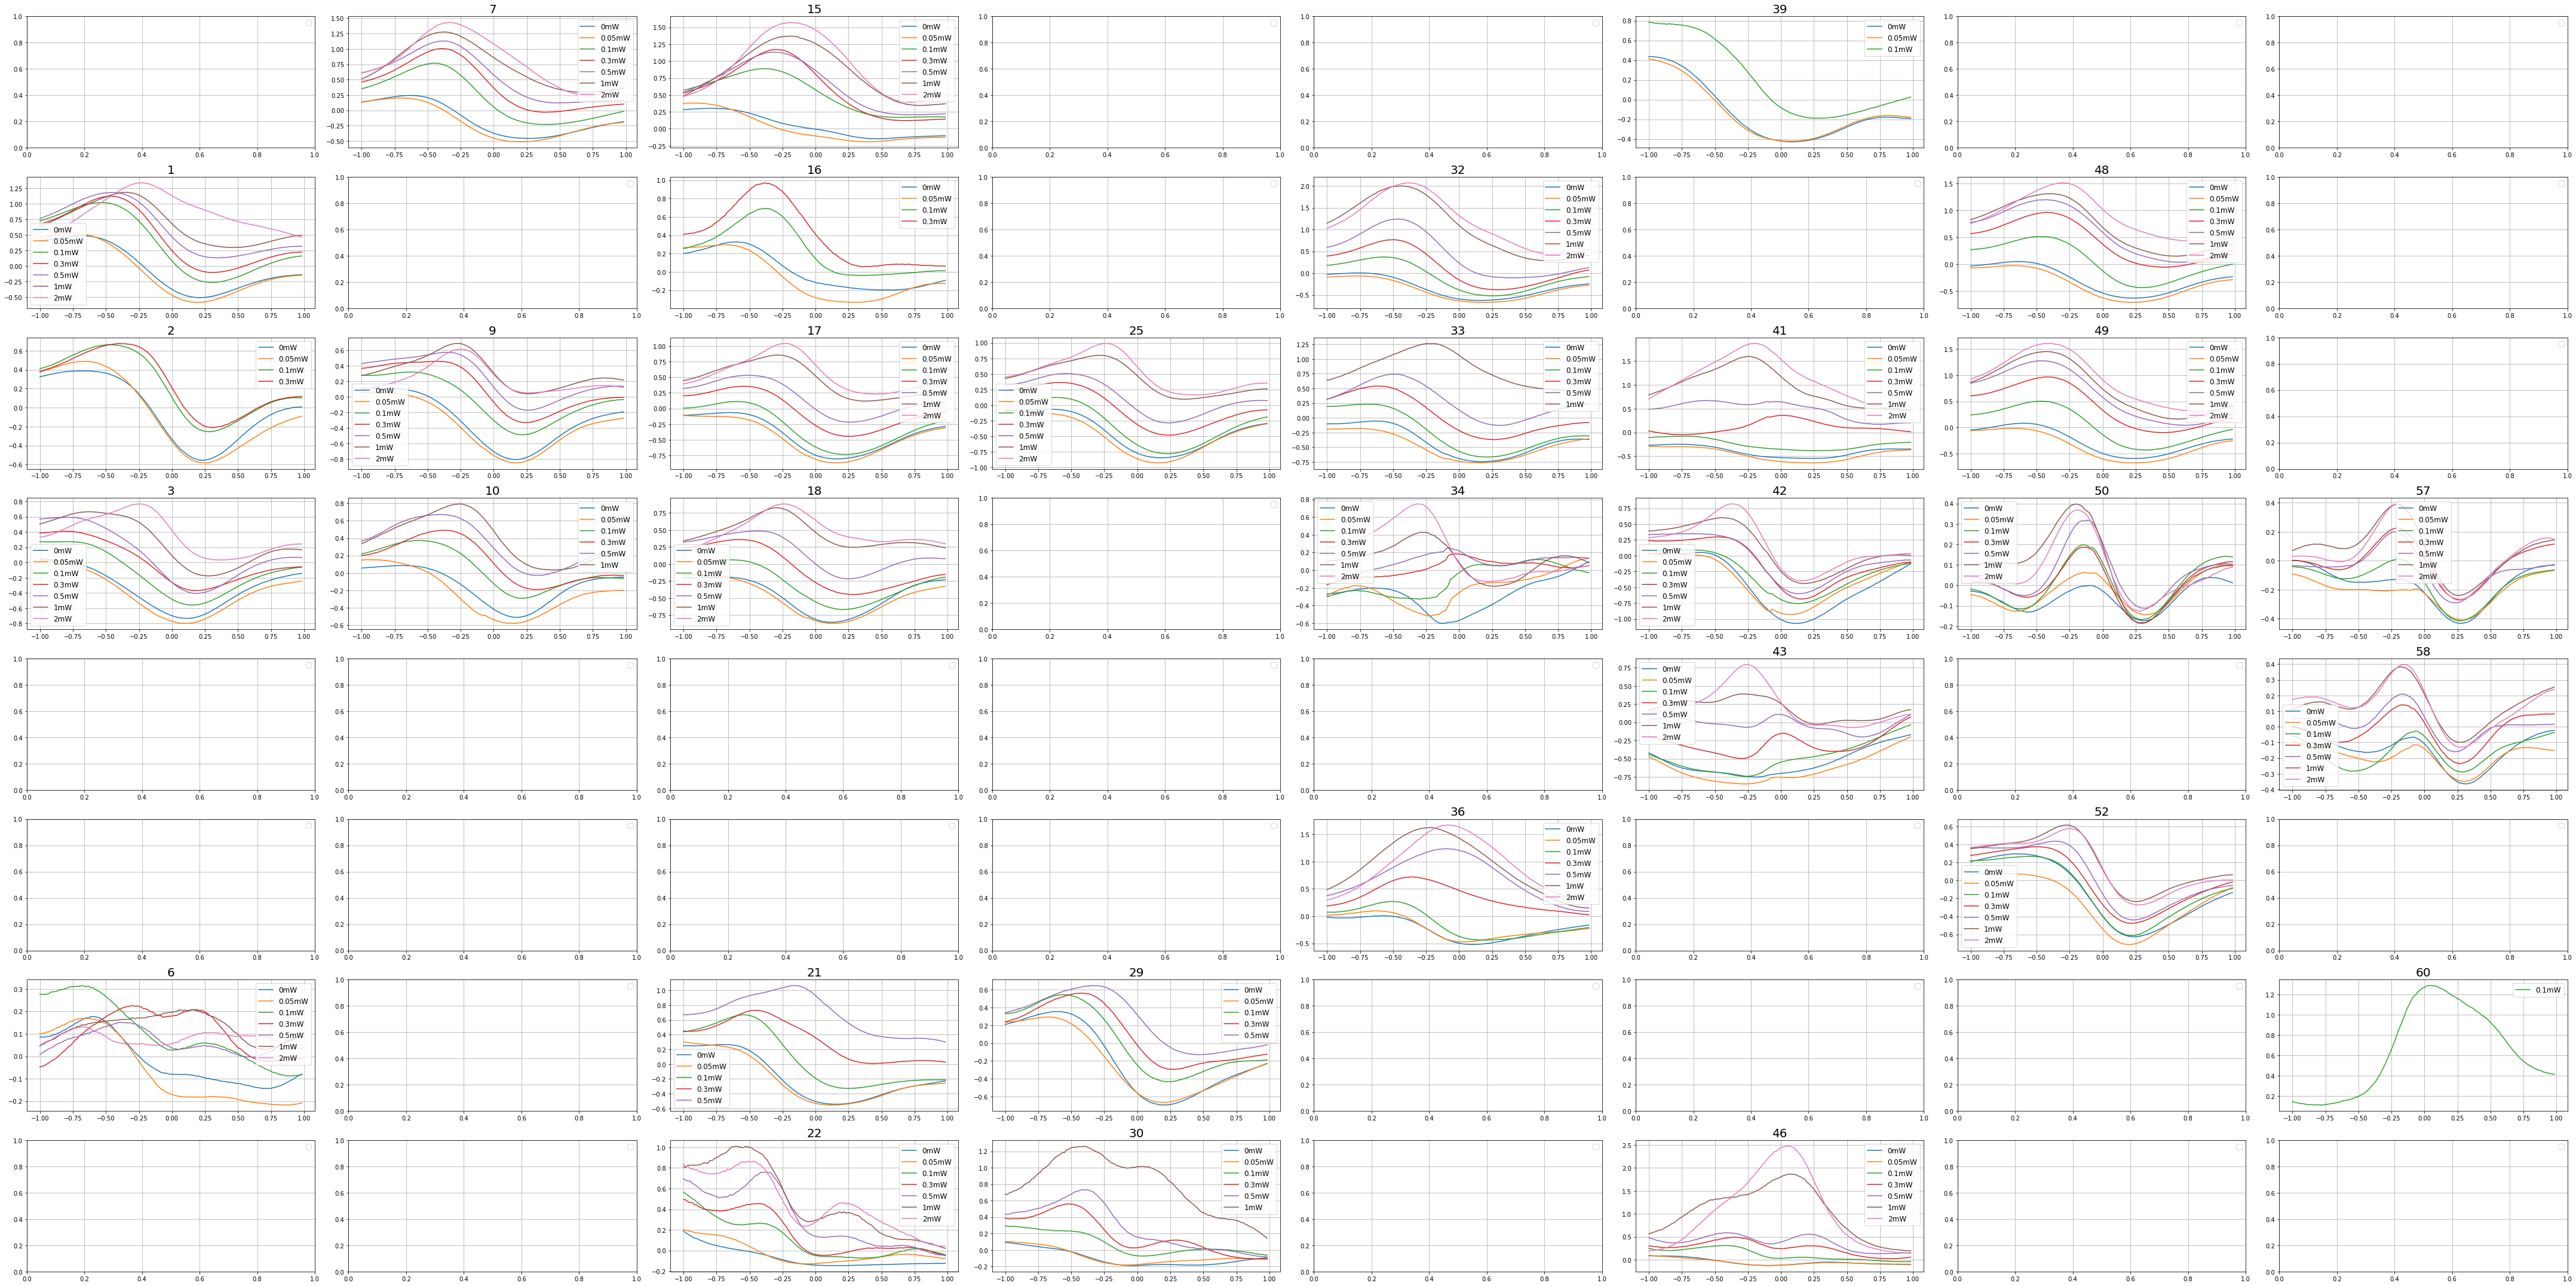

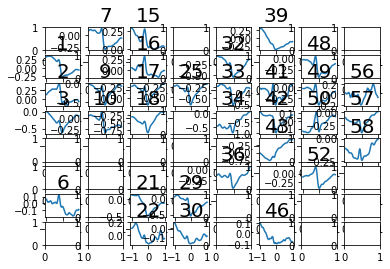

In [18]:
bI = [0, 0.05, 0.1, 0.3, 0.5, 1, 2]
direction = 'UD'
for Fc in [1,4]:
    fig, ax = plt.subplots(nrows=8, ncols=8)
    cmind = 0
    files = ['merge_0727_OUsmooth_Bright_'+direction+'_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz',
             'merge_0727_OUsmooth_'+direction+'_G4.5_5min_Q100_0.05mW_12900_'+str(Fc)+'Hz',
             'merge_0727_OUsmooth_'+direction+'_G4.5_5min_Q100_0.1mW_6400_'+str(Fc)+'Hz',
             'merge_0727_OUsmooth_'+direction+'_G4.5_5min_Q100_0.3mW_2067_'+str(Fc)+'Hz',
             'merge_0727_OUsmooth_'+direction+'_G4.5_5min_Q100_0.5mW_1200_'+str(Fc)+'Hz',
             'merge_0727_OUsmooth_'+direction+'_G4.5_5min_Q100_1mW_550_'+str(Fc)+'Hz',
             'merge_0727_OUsmooth_'+direction+'_G4.5_5min_Q100_2mW_225_'+str(Fc)+'Hz']
    for i in range(len(files)):
        loadfiles = np.load(exp_folder+'STA\\STA_'+files[i]+'.npz', allow_pickle=True)
        for k in loadfiles.files:
            vars()[k] = loadfiles[k][()]

        for cn in range(60):
            STA = STA_cell[cn]
            if type(STA) == int: continue
            ax[np.where(figmap == cn+1)][0].plot(timeshift, STA, label=str(bI[i])+'mW', color = plt.cm.tab10(cmind))
            ax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 20)
        cmind += 1

    for ax1d in ax:
        for ax in ax1d:
            ax.legend(fontsize = 12)
            ax.grid()

    fig.set_size_inches(60, 30)
    fig.tight_layout()
    fig.savefig(exp_folder+'STA\\Fig\\dBackIn_BB.tif', bbox_inches = 'tight',pad_inches = 0.3)  